In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import re #pattern searching in a string
import plotly.express as px
import plotly as py
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import warnings
warnings.filterwarnings("ignore")

In [2]:
df20 = pd.read_csv("Data_set/data_2020.csv", parse_dates=['transaction_date'])
df21 = pd.read_csv("Data_set/data_2021.csv", parse_dates=['transaction_date'])
df22 = pd.read_csv("Data_set/data_2022.csv", parse_dates=['transaction_date'])
df = pd.concat([df20,df21,df22],axis=0)


In [3]:
df_test1 = df.copy(deep=False)

In [4]:
def find_nan(df):
    columns = df.columns
    col_values = df.isna().sum().values
    temp = pd.DataFrame(data=col_values,index=columns,columns=['missing_count'])
    temp['percent_missing'] = np.round((temp['missing_count'] / df.shape[0]) *100 ,2)
    return temp

find_nan(df)

,missing_count,percent_missing
user_id,0,0.00
bill_id,0,0.00
line_item_amount,0,0.00
bill_discount,0,0.00
transaction_date,0,0.00
description,14,0.00
inventory_category,640313,11.87
colour,15344,0.28
size,15344,0.28
zone_name,0,0.00


In [5]:
df.description = df.description.fillna(df.inventory_category)
df.description = df.description.fillna("Misc")

def get_product(txt,pattern):
    if isinstance(txt, str):

        #search and check if split word exists
        searched_word = re.search(pattern, txt)
        
        #word exists
        if searched_word:
            splitted_string = re.split(pattern, txt)[0]
            # check if empty list is returned->when there is only pattern available in 'txt'
            if splitted_string == '':
                return 'Misc'
            else:
                return splitted_string.strip()
            
        #split word not exists(but the product name can still be present , so we'll need the entire string)
        else:
            return txt
        
    # any other value found other than string datatype
    else:
        return 'Misc'
    
df['desc_copy'] = df['description'].copy()
df['desc_copy'] = df['desc_copy'].fillna('Misc')

#for patterns starting with IT,CORE-, A16-,A17-,S16-,S18-,TBA07SD7890(LENGTH=11)
df[['product']] = df[['desc_copy']].applymap(lambda row:get_product(row,pattern=r'IT[A-Z0-9]+|CORE-|\b[A-Z]\d{2}-|\b[A-Z0-9]{11}\b')) 

#product names are acronyms are their lengths are not greater than 2.
df[['product']] = df[['product']].applymap(lambda row: 'Misc' if len(row.split())>=2 else row)

df['ic_copy'] = df['inventory_category'].copy()
df['ic_copy'] = df['ic_copy'].fillna('Misc')
df[['ic_copy']] = df[['ic_copy']].applymap(lambda row: re.sub(r'na','',row,flags=re.IGNORECASE))

df['colour'] = df['colour'].fillna('Misc')
df['colour'] = df['colour'].str.replace('NOT-CAPTURED','Misc')

df['size'] = df['size'].fillna('Misc')
df['size'] = df['size'].str.replace('NOT-CAPTURED','Misc')

## IDENTIFYING COLOURS
all_colours = df['colour'].value_counts().index.tolist()
pattern = r'\b(?:' + '|'.join(re.escape(color)  for color in all_colours if isinstance(color,str)) + r')\b'

def find(txt,pattern):
    x = re.findall(pattern, txt,flags=re.IGNORECASE)
    if x==[]:
        return ('Misc')
    return ' '.join(x)

print('Unique colours count before:',len(df['colour'].unique()))

unknown_colours_bef = df[df['colour']=='Misc'].shape[0]
df.loc[(df['colour']=='Misc'),'colour'] = df.loc[(df['colour']=='Misc'),'ic_copy'].map(lambda row: find(row,pattern))
unknown_colours_after = df[df['colour']=='Misc'].shape[0]
print('Colours found: ',unknown_colours_bef - unknown_colours_after)

print('Unique colours count after:',len(df['colour'].unique()))

## IDENTIFYING SIZE
all_size = df['size'].unique().tolist()
pattern = r'\b(?:' + '|'.join(re.escape(size) for size in all_size if isinstance(size,str)) + r')\b'

print('Unique size count before:',len(df['size'].unique()))

unknown_size_bef = df[df['size']=='Misc'].shape[0]
df.loc[(df['size']=='Misc'),'size'] = df.loc[(df['size']=='Misc'),'ic_copy'].map(lambda row: find(row,pattern))
df.loc[(df['size']=='Misc'),'size'] = df.loc[(df['size']=='Misc'),'ic_copy'].map(lambda row: find(row,r'\d*x\d*x\d*|\d*mm|\d*cm|\d*m'))
unknown_size_after = df[df['size']=='Misc'].shape[0]
print('Sizes found: ',unknown_size_bef - unknown_size_after)

print('Unique size count after:',len(df['size'].unique()))

replace = {'TR':'MENS TROUSER',
'MSP':'MENS SPORTSCOAT',
'BSP':'MENS SPORTSCOAT',
'TWB': 'MENS TROUSER WITH BELT',
'JKT': 'MENS JACKET',
'SH':'MENS SHIRT',
'MSH':'MENS SHIRT',
'MTR':'MENS TROUSER WITH BELT',
'MBL':'MENS BELT',
'BLT':'MENS BELT',
'SR':'MENS SHORTS',
'MTS':'MENS T-SHIRT',
'TS':'MENS T-SHIRT',
'BSH':'BOYS SHIRT',
'SW':'MENS SWEATER',
'BDE':'BOYS DENIM',
'MFW':'MENS FOOTWEAR',
'FW':'MENS FOOTWEAR',
'BDNM':'BOYS DENIM',
'SX':'MENS SOCKS',
'MSO':'MENS SHORTS',
'SO':'MENS SHORTS',
'MDE':'MENS DENIM',
'BTS':'BOYS T-SHIRT',
'BSO':'BOYS SHORTS',
'MDNM':'MENS DENIM',
'BTR':'BOYS TROUSER',
'MSW':'MENS SWEATER',
'SCKS':'MENS SOCKS',
'MSX':'MENS SOCKS',
'BSW':'BOYS SWEATER',
'MJKT':'MENS JACKET',
'MJA':'MENS JACKET',
'BJKT':'BOYS JACKET',
'BJO':'BOYS Jogger',
'MSC':'MENS JACKET',
'BS':'BOYS SHIRT',
'MWL':'Mens Wallet - Sportswear',
'BJA':'BOYS JACKET',
'BSR':'BOYS SHORTS',
'MDN':'MENS Denim Trouser',
'BDN':'Boys Denim Trouser - Jeanswear',
'KT':'MENS KNIT TROUSER',
'MJGR':'MENS JOGGER',
'TBG':'Trolley Bag',
'CBG':'CARRY BAG',
'MTIE':'MALE TIE',
'MJO':'MENS JOGGER',
'MWC':'MENS BANDI'}

df['inventory_category'] = df['product'].map(lambda x: replace[x] if x in replace.keys() else x)

Unique colours count before: 344
Colours found:  2259362
Unique colours count after: 390
Unique size count before: 52
Sizes found:  2567244
Unique size count after: 107


In [6]:
find_nan(df)

,missing_count,percent_missing
user_id,0,0.0
bill_id,0,0.0
line_item_amount,0,0.0
bill_discount,0,0.0
transaction_date,0,0.0
description,0,0.0
inventory_category,0,0.0
colour,0,0.0
size,0,0.0
zone_name,0,0.0


In [7]:
# extract weekday and month from transaction date
df['month'] = df['transaction_date'].dt.month_name().map({'January':1, 'February':2,'March':3, 'April':4, 'May':5,  'June':6, 'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12})
df['weekday'] = df['transaction_date'].dt.day_name().map({'Monday':1, 'Tuesday':2,'Wednesday':3, 'Thursday':4, 'Friday':5,  'Saturday':6, 'Sunday':7})
df['zone_name'] = df['zone_name'].map({'East':1, 'South':2, 'North':3, 'West':4, 'ROOT':5, 'Central':6}).astype(int)

In [8]:
price_df = df.copy(deep=False)

In [9]:
from datetime import datetime
import datetime as dt
df["transaction_date"] = df["transaction_date"].dt.date
snapshot_date = max(df.transaction_date) + dt.timedelta(days=1)

In [10]:
rfm = df.groupby('user_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days, 
    'bill_id': lambda x: len(x.unique()), 
    'line_item_amount': lambda x: x.sum(), 
    'bill_discount': lambda x: x.sum(), 
    'product': lambda x: x.count()
    }).reset_index()
rfm['transaction_date'] = rfm['transaction_date'].astype(int)
# Rename columns
rfm.rename(columns={'transaction_date': 'Recency', 
                         'bill_id': 'Frequency', 
                         'line_item_amount': 'MonetaryValue','bill_discount':'DiscountValue', 'product':'Product'}, inplace=True)

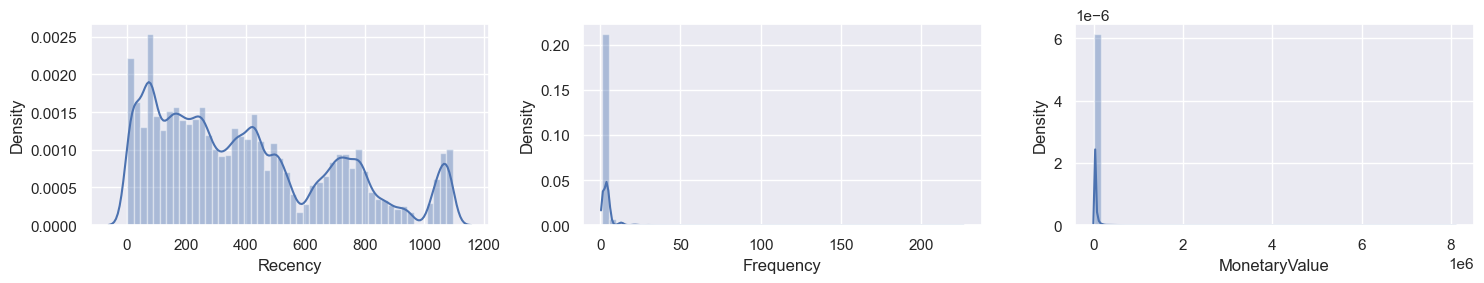

In [15]:


fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(rfm['Recency'], ax=ax[0])
sns.distplot(rfm['Frequency'], ax=ax[1])
sns.distplot(rfm['MonetaryValue'], ax=ax[2])
plt.tight_layout()
plt.show()



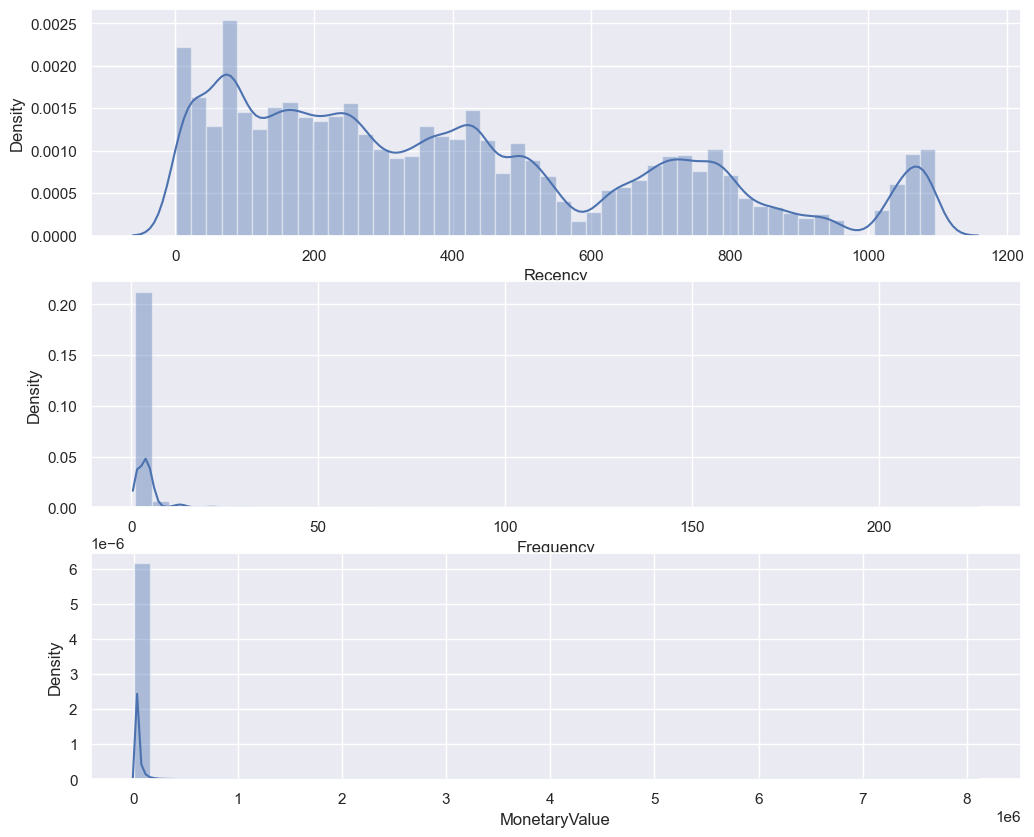

In [14]:
plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(rfm['MonetaryValue'])

# Show the plot
plt.show()

In [16]:
from scipy import stats
def analyze_skewness(x):
    fig, ax = plt.subplots(2, 2, figsize=(5,5))
    sns.distplot(rfm[x], ax=ax[0,0])
    sns.distplot(np.log(rfm[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(rfm[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(rfm[x])[0], ax=ax[1,1])
    plt.tight_layout()
    plt.show()
    
#     print(rfm[x].skew().round(2))
#     print(np.log(rfm[x]).skew().round(2))
#     print(np.sqrt(rfm[x]).skew().round(2))
#     print(pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))
    
    print('Log Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.log(rfm[x]).skew().round(2))
    print('Square Root Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', np.sqrt(rfm[x]).skew().round(2))
    print('Box-Cox Transform : The skew coefficient of', rfm[x].skew().round(2), 'to', pd.Series(stats.boxcox(rfm[x])[0]).skew().round(2))

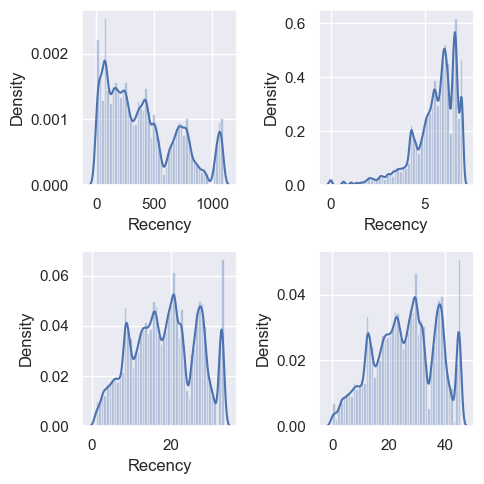

Log Transform : The skew coefficient of 0.66 to -1.45
Square Root Transform : The skew coefficient of 0.66 to -0.03
Box-Cox Transform : The skew coefficient of 0.66 to -0.16


In [17]:
analyze_skewness("Recency")

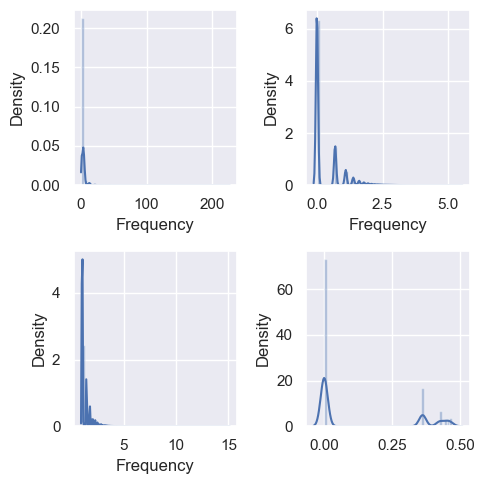

Log Transform : The skew coefficient of 15.39 to 1.93
Square Root Transform : The skew coefficient of 15.39 to 3.91
Box-Cox Transform : The skew coefficient of 15.39 to 0.86


In [18]:
analyze_skewness("Frequency")

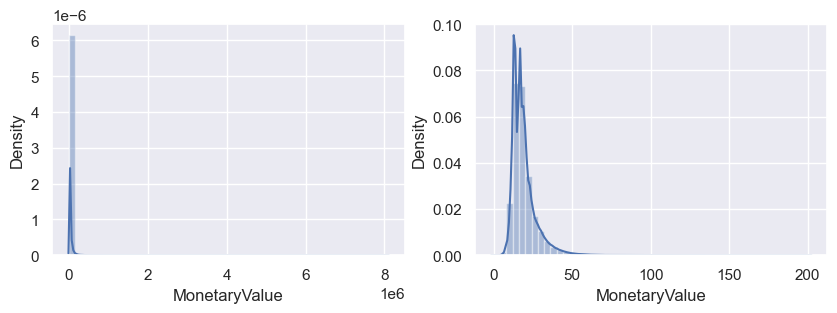

66.32
2.27


In [19]:


fig, ax = plt.subplots(1, 2, figsize=(10,3))
sns.distplot(rfm['MonetaryValue'], ax=ax[0])
sns.distplot(np.cbrt(rfm['MonetaryValue']), ax=ax[1])
plt.show()
print(rfm['MonetaryValue'].skew().round(2))
print(np.cbrt(rfm['MonetaryValue']).skew().round(2))



In [20]:
pd.Series(np.cbrt(rfm['MonetaryValue'])).values


array([20.6495118 , 29.00039627, 25.32690774, ..., 20.94999455,
       19.12566746, 17.32256025])

In [11]:
# Set the Numbers
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(rfm['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(rfm['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['MonetaryValue'])).values
customers_fix["DiscountValue"]  = pd.Series(np.cbrt(rfm['DiscountValue'])).values
customers_fix["Product"] = stats.boxcox(rfm['Product'])[0]
customers_fix.tail()

,Recency,Frequency,MonetaryValue,DiscountValue,Product
643776,20.218111,0.0,17.322563,18.978732,1.167247
643777,20.065915,0.0,20.405875,29.782875,1.437462
643778,22.356589,0.0,20.949995,19.574338,1.319416
643779,22.176344,0.0,19.125667,19.309788,1.167247
643780,18.121678,0.0,17.322560,25.194221,1.167247


In [12]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_fix)
customers_normalized = scaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0. -0. -0.  0.  0.]
[1. 1. 1. 1. 1.]


In [23]:
pd.DataFrame(customers_normalized).head(3)

,0,1,2,3,4
0,-0.455966,1.256766,0.213462,-0.320487,0.922435
1,0.198714,1.747769,1.294505,1.904528,1.129113
2,-0.083692,1.587543,0.818963,-0.320487,0.999124


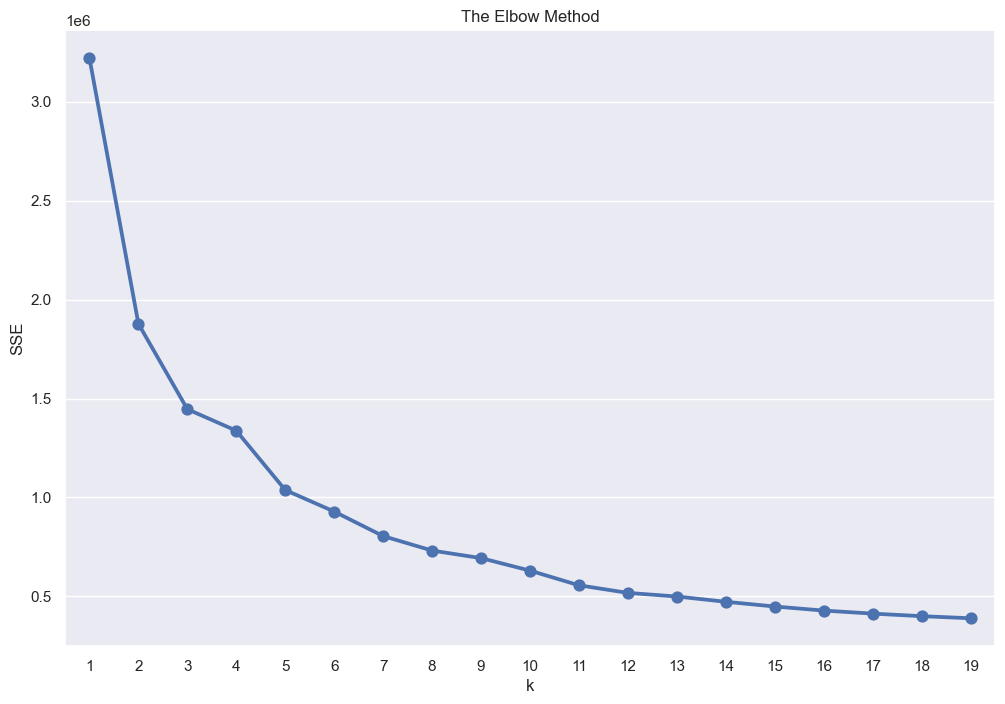

In [45]:
plt.figure(figsize=(12,8))

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
K = range(1, 20)

distortions = []
inertias = []
mapping1 = {}
sse = {}
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    
    distortions.append(sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / customers_normalized.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(customers_normalized, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / customers_normalized.shape[0]
    
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [46]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 1.96875705369015
2 : 1.4974057057216987
3 : 1.3430356934368268
4 : 1.303551851252584
5 : 1.124292031114799
6 : 1.06683462383651
7 : 0.9716552172065428
8 : 0.9278547365207485
9 : 0.9120725009512979
10 : 0.875729161907328
11 : 0.8140837230465713
12 : 0.7712712720399706
13 : 0.7633685900529363
14 : 0.7294977304283989
15 : 0.7033931740252861
16 : 0.6739717868947284
17 : 0.6678313512636329
18 : 0.6595278665059039
19 : 0.6541796998541356


In [47]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(643781,)

In [48]:
rfm["Cluster"] = model.labels_
rfm.head()

,user_id,Recency,Frequency,MonetaryValue,DiscountValue,Product,Cluster
0,50049,205,2,8805.0001,0.0,10,2
1,50174,386,5,24389.9998,2000.0,13,0
2,50511,300,3,16246.0021,0.0,11,2
3,50565,138,4,14108.0010,2478.0,15,0
4,53762,701,1,5397.9999,0.0,3,1


In [49]:
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'],'DiscountValue':['mean', 'count'] , 'Product':'count' }).round(1)

Recency Frequency MonetaryValue         DiscountValue         Product
           mean      mean          mean   count          mean   count   count
Cluster                                                                      
0         180.8       7.2       57460.5   45094       12267.0   45094   45094
1         447.3       1.0        4295.7  443695          47.4  443695  443695
2         327.1       2.8       17959.2  154992         118.9  154992  154992

In [69]:
model = KMeans(n_clusters=5, random_state=42)
model.fit(customers_normalized)
model.labels_.shape
rfm["Cluster"] = model.labels_
rfm.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count'],'DiscountValue':['mean', 'count'] , 'Product':'count' }).round(1)

Recency Frequency MonetaryValue         DiscountValue         Product
           mean      mean          mean   count          mean   count   count
Cluster                                                                      
0         247.3       3.6       18173.7   42394        3562.4   42394   42394
1         667.6       1.0        3815.8  246792          26.3  246792  246792
2         133.3      11.1      102526.6   19330       22117.5   19330   19330
3         332.5       2.8       19095.3  135373           2.4  135373  135373
4         172.4       1.0        5010.9  199892          36.1  199892  199892

In [70]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue', 'DiscountValue', 'Product'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
df_normalized.head()

,Recency,Frequency,MonetaryValue,DiscountValue,Product,ID,Cluster
0,-0.455966,1.256766,0.213462,-0.320487,0.922435,0,3
1,0.198714,1.747769,1.294505,1.904528,1.129113,1,0
2,-0.083692,1.587543,0.818963,-0.320487,0.999124,2,3
3,-0.783084,1.698200,0.668323,2.069286,1.236132,3,0
4,1.003805,-0.669328,-0.188821,-0.320487,-0.225835,4,1


In [71]:
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue','DiscountValue','Product'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,0,3,Recency,-0.455966
1,1,0,Recency,0.198714
2,2,3,Recency,-0.083692
3,3,0,Recency,-0.783084
4,4,1,Recency,1.003805


In [72]:
fig3 = df_nor_melt.groupby('Cluster').agg({'ID': lambda x: len(x)}).reset_index()


# Rename columns
fig3.rename(columns={'ID': 'Count'}, inplace=True)
fig3['percent'] = (fig3['Count'] / fig3['Count'].sum()) * 100
fig3['percent'] = fig3['percent'].round(1)

fig3.head()

,Cluster,Count,percent
0,0,211970,6.6
1,1,1233960,38.3
2,2,96650,3.0
3,3,676865,21.0
4,4,999460,31.0


In [73]:
colors=['#bad0af','#d5e0cf','#f1f1f1','#f1d4d4'] #color palette
import plotly.express as px

fig = px.treemap(fig3, path=['Cluster'],values='Count'
                 , width=800, height=400
                 ,title="Distribution of Cluster")

fig.update_layout(
    treemapcolorway = colors, #defines the colors in the treemap
    margin = dict(t=50, l=25, r=25, b=25))

fig.data[0].textinfo = 'label+text+value+percent root'
fig.show()

<Axes: xlabel='Attribute', ylabel='Value'>

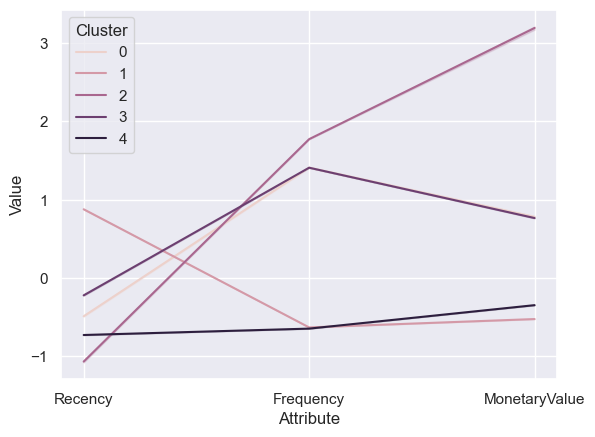

In [80]:
#sns_df = pd.DataFrame(df_nor_melt,columns=['Recency', 'Frequency', 'MonetaryValue'])
sns_df = df_nor_melt[df_nor_melt['Attribute'].isin(['Recency', 'Frequency', 'MonetaryValue'])]
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=sns_df)

<Axes: xlabel='Attribute', ylabel='Value'>

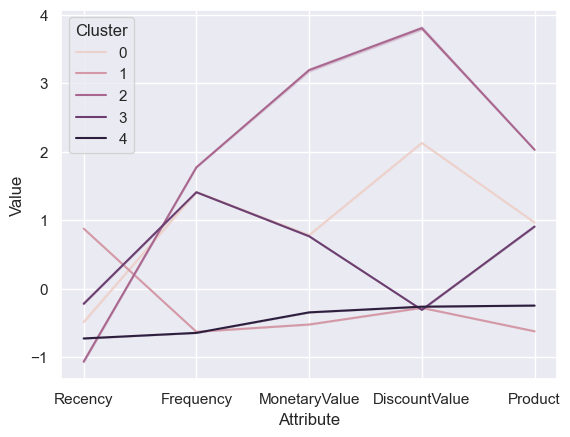

In [81]:
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=df_nor_melt)

2: recent transaction, frequent by, high value transction (loyal)
4: last transaction while ago, not frequent, low value transction 
0: log time ago transction, frequent buy, hign value (new customer buy discounted product)
3: log time ago tranction, frquent buy, high value (new customer not buy discounted product)
1: very log back transction, low frequncy, low value   (lost customer)